In [1]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")
sys.path.insert(0, "/home/j/joppich/.local/lib/python3.11/site-packages/")
print(sys.path)

%autoreload 2
from mikg.kgraph import *
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import leidenalg as la

from collections import defaultdict, Counter

import random
random.seed(42)

import pickle

['/home/j/joppich/.local/lib/python3.11/site-packages/', '../', '/mnt/raidbio/extproj/projekte/regulatory_networks/simulated_data', '', '/mnt/biosoft/software/python/3.11/lib/python3.11/site-packages', '/mnt/biosoft/software/python/3.11/lib64/python3.11/site-packages', '/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '/home/j/joppich/.local/lib/python3.11/site-packages', '/usr/lib64/python3.11/site-packages', '/usr/lib64/python3.11/_import_failed', '/usr/lib/python3.11/site-packages']


In [2]:
simulatedGenes = pd.read_csv("./simulated_changes_detail.tsv", sep="\t")
simulatedGenes

,wildtype,stage1,stage2,stage3,geneset,trend,element_type,gene
0,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,ADM
1,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,BUB1
2,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,DUSP5
3,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,EGR1
4,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,EGR3
...,...,...,...,...,...,...,...,...
414,1,2,2,8,REACTOME_PI5P_REGULATES_TP53_ACETYLATION,trend4,gene,TP53
415,1,2,2,8,REACTOME_PI5P_REGULATES_TP53_ACETYLATION,trend4,tf,E2F1
416,1,2,2,8,REACTOME_PI5P_REGULATES_TP53_ACETYLATION,trend4,tf,SP1
417,1,2,2,8,REACTOME_PI5P_REGULATES_TP53_ACETYLATION,trend4,tf,STAT1


In [3]:
set(simulatedGenes["geneset"])

{'AMIT_EGF_RESPONSE_40_MCF10A',
 'BIOCARTA_ERBB3_PATHWAY',
 'BIOCARTA_FEEDER_PATHWAY',
 'BIOCARTA_IL22BP_PATHWAY',
 'BIOCARTA_RNAPOL3_PATHWAY',
 'BIOCARTA_SARS_PATHWAY',
 'BIOCARTA_SET_PATHWAY',
 'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP',
 'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN',
 'DASU_IL6_SIGNALING_DN',
 'FARDIN_HYPOXIA_9',
 'FINETTI_BREAST_CANCER_KINOME_RED',
 'GHO_ATF5_TARGETS_UP',
 'GREENBAUM_E2A_TARGETS_DN',
 'HEDENFALK_BREAST_CANCER_BRACX_UP',
 'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE',
 'IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN',
 'IM_SREBF1A_TARGETS',
 'KEGG_MEDICUS_REFERENCE_AUTOPHAGY_VESICLE_NUCLEATION_ELONGATION_MATURATION_E3_UBIQUITIN_LIGASE_MALIN',
 'KEGG_MEDICUS_REFERENCE_COPII_VESICLE_FORMATION',
 'KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS',
 'KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RAS_ERK_SIGNALING_MRAS_SHOC2_PP1_HOLOPHOSPHATASE',
 'KIM_GERMINAL_CENTER_T_HELPER_DN',
 'MCBRYAN_TERMINAL_END_BUD_DN',
 'MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN',
 'MUNS

In [4]:
simulatedNetwork = pd.read_csv("./simulated_network.tsv", sep="\t", usecols=["TF", "gene"])
simulatedNetwork

,TF,gene
0,CEBPB,ADM
1,TP53,EGR1
2,NFATC2,EGR3
3,FOS,FOS
4,JUN,FOS
...,...,...
119,SP1,UGCG
120,EGR1,EP300
121,E2F1,PIN1
122,HMGA1,TP53


In [5]:
trend2gene = defaultdict(set)
trend2pathways = defaultdict(set)
pathways2genes = defaultdict(set)
gene2type = defaultdict(set)
gene2trends = defaultdict(set)

for ri, row in simulatedGenes.iterrows():

    trend2gene[row["trend"]].add(row["gene"])
    trend2pathways[row["trend"]].add(row["geneset"])
    pathways2genes[row["geneset"]].add(row["gene"])

    gene2type[row["gene"]].add(row["element_type"])
    gene2trends[row["gene"]].add(row["trend"])
    

In [6]:
for trend in trend2pathways:
    print(trend, len(trend2pathways[trend]), len(trend2gene[trend]))

trend1 10 141
trend2 10 100
trend3 10 89
trend4 10 79


In [7]:
stageSort = {
    "wildtype": 0,
    "stage1": 1,
    "stage2": 2,
    "stage3": 3
}

basedir = "comms"

In [8]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [9]:
kg

KGraph KGraph with 110407 nodes and 1573605 edges

In [10]:
kg.get_edge_between_type()

Counter({('gene', 'geneset'): 841157,
         ('gene', 'gene'): 344408,
         ('TF;gene', 'gene'): 95771,
         ('geneset', 'geneset'): 74634,
         ('TF;gene', 'geneset'): 74544,
         ('gene', 'disease'): 43297,
         ('disease', 'drug'): 35017,
         ('gene', 'TF;gene'): 19994,
         ('TF;gene', 'TF;gene'): 16120,
         ('gene', 'drug'): 7899,
         ('miRNA;ncRNA', 'gene'): 7848,
         ('TF;gene', 'disease'): 5105,
         ('TF;gene', 'miRNA;ncRNA'): 2099,
         ('miRNA;ncRNA', 'TF;gene'): 1808,
         ('gene', 'disease;geneset'): 1714,
         ('gene', 'miRNA;ncRNA'): 651,
         ('gene;lncRNA;ncRNA', 'geneset'): 444,
         ('TF;gene', 'drug'): 341,
         ('geneset', 'disease;geneset'): 200,
         ('TF;gene', 'disease;geneset'): 147,
         ('gene;lncRNA;ncRNA', 'gene'): 120,
         ('disease;geneset', 'geneset'): 95,
         ('lncRNA;ncRNA', 'gene'): 49,
         ('gene', 'gene;lncRNA;ncRNA'): 36,
         ('disease;geneset', '

In [11]:
containedEdges = 0
for ri, row in simulatedNetwork.iterrows():
    edgeContained = (row["TF"], row["gene"]) in kg.kg.edges
    if edgeContained:
        containedEdges += 1

    if not edgeContained:
        print(row["TF"], row["gene"], edgeContained)

print(containedEdges, ri+1, containedEdges/(ri+1))

FOS FOS False
JUN JUN False
TNFAIP3 JUN False
RBMX JUND False
ZFP36 VEGFA False
ZFP36L1 VEGFA False
RBMX JUNB False
SMAD4 PDGFRA False
APC SGK1 False
PER1 BAX False
IRF1 MAPK14 False
SERTAD1 SET False
TP53 TP53 False
111 124 0.8951612903225806


In [12]:
simNetwork = pd.read_csv("./simulated_network.tsv", sep="\t")
simNetwork.head()

,TF,gene
0,CEBPB,ADM
1,TP53,EGR1
2,NFATC2,EGR3
3,FOS,FOS
4,JUN,FOS


In [13]:
for ri, row in simNetwork.iterrows():
    et = (row["TF"], row["gene"])
    edge = et in kg.kg.edges
    edge_r = tuple(et[::-1]) in kg.kg.edges

    if not edge and not edge_r:
        print(et, edge, edge_r)
    

('FOS', 'FOS') False False
('JUN', 'JUN') False False
('RBMX', 'JUND') False False
('ZFP36', 'VEGFA') False False
('ZFP36L1', 'VEGFA') False False
('RBMX', 'JUNB') False False
('SMAD4', 'PDGFRA') False False
('APC', 'SGK1') False False
('PER1', 'BAX') False False
('IRF1', 'MAPK14') False False
('SERTAD1', 'SET') False False
('TP53', 'TP53') False False


In [14]:
exprDF = pd.read_csv("./expression_simulated_mean_df.tsv", sep="\t")

In [15]:
exprDF.head()

,group,gene,min,percentile_25,median,percentile_75,max,mean,num,sd,group_cells,perc_expr
0,stage1,A1BG,0.135103,0.299755,0.369649,0.448072,0.762750,0.381845,69,0.123641,5419,0.012733
1,stage1,A1BG.AS1,0.138112,0.319603,0.387099,0.479105,1.044375,0.404958,308,0.144913,5419,0.056837
2,stage1,A2M,0.119602,0.361211,0.468807,0.657032,2.089658,0.528361,746,0.244020,5419,0.137664
3,stage1,A2M.AS1,0.133371,0.304632,0.382526,0.477938,0.992434,0.397057,321,0.133843,5419,0.059236
4,stage1,A2ML1.AS1,0.119602,0.388011,0.509231,0.755049,2.050669,0.600180,747,0.296454,5419,0.137848


In [16]:
exprDFs = {}

for group in sorted(exprDF.group.unique(), key=lambda x: stageSort.get(x, -1)):
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['wildtype', 'stage1', 'stage2', 'stage3']


In [17]:
kg.get_node_types()

Counter({'geneset': 55163,
         'gene': 41923,
         'disease': 7781,
         'drug': 3195,
         'TF;gene': 1629,
         'miRNA;ncRNA': 593,
         'disease;geneset': 61,
         'lncRNA;ncRNA': 36,
         'gene;lncRNA;ncRNA': 26})

In [18]:
kg.get_edge_types()

Counter({'part_of': 705930,
         'interacts': 434239,
         'relevant_in': 204493,
         'activates': 158594,
         'affected_by': 35051,
         'represses': 27058,
         'target_of': 8240})

In [19]:
exprKGs = {}

gsa = GenesetAnnotator()
mNS = MeanNetworkScorer()

for group in exprDFs:
    
    print(group)
    
    gKG = KGraph()
    
    gKG.load_kgraph("../data/initial_base_graph.out")

    gKG.add_gene_expression(exprDFs[group])
    mNS.score_nodes_from_properties(gKG)

    mNS.score(gKG)

    gsa.annotate_genesets(gKG, settype="disease", targettype="gene")
    gsa.annotate_genesets(gKG, settype="geneset", targettype="gene")
    gsa.annotate_genesets(gKG, settype="ncRNA", targettype="gene")
        
    exprKGs[group] = gKG

wildtype
Measured Genes 15099
Found Genes 14018


/mnt/raidbio/extproj/projekte/regulatory_networks/simulated_data/../mikg/kgraph.py:1403: RuntimeWarning: invalid value encountered in scalar divide
  edge_zscore = (edge_score-etype2mean[etype])/etype2std[etype]


Processed 7884 of 43578 target nodes for settype=disease and targettype=gene
Processed 42801 of 43578 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43578 target nodes for settype=ncRNA and targettype=gene
stage1
Measured Genes 15099
Found Genes 14019
Processed 7884 of 43578 target nodes for settype=disease and targettype=gene
Processed 42801 of 43578 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43578 target nodes for settype=ncRNA and targettype=gene
stage2
Measured Genes 15096
Found Genes 14015
Processed 7884 of 43578 target nodes for settype=disease and targettype=gene
Processed 42801 of 43578 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43578 target nodes for settype=ncRNA and targettype=gene
stage3
Measured Genes 15094
Found Genes 14014
Processed 7884 of 43578 target nodes for settype=disease and targettype=gene
Processed 42801 of 43578 target nodes for settype=geneset and targettype=gene
Processed 3390 of

In [20]:
stage2trend = {
    "wildtype": "trend2",
    "stage1": "trend1",
    "stage2": "trend3",
    "stage3": "trend4"
}

In [21]:
DiffKG = DifferentialKG()

In [22]:
dkg = DiffKG.get_differential_graph(exprKGs["stage2"], exprKGs["stage1"])

/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/home/j/joppich/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/j/joppich/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [23]:
trend2pathways

defaultdict(set,
            {'trend1': {'AMIT_EGF_RESPONSE_40_MCF10A',
              'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP',
              'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN',
              'DASU_IL6_SIGNALING_DN',
              'FARDIN_HYPOXIA_9',
              'FINETTI_BREAST_CANCER_KINOME_RED',
              'GHO_ATF5_TARGETS_UP',
              'GREENBAUM_E2A_TARGETS_DN',
              'HEDENFALK_BREAST_CANCER_BRACX_UP',
              'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE'},
             'trend2': {'IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN',
              'IM_SREBF1A_TARGETS',
              'KIM_GERMINAL_CENTER_T_HELPER_DN',
              'MCBRYAN_TERMINAL_END_BUD_DN',
              'MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN',
              'MUNSHI_MULTIPLE_MYELOMA_DN',
              'PETRETTO_LEFT_VENTRICLE_MASS_QTL_CIS_DN',
              'RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_DN',
              'STONER_ESOPHAGEAL_CARCINOGENESIS_DN',
              'TSUDA_ALVEOLAR_SOFT

Text(0.5, 1.0, 'Cumulative Histogram of Gene Fold Changes')

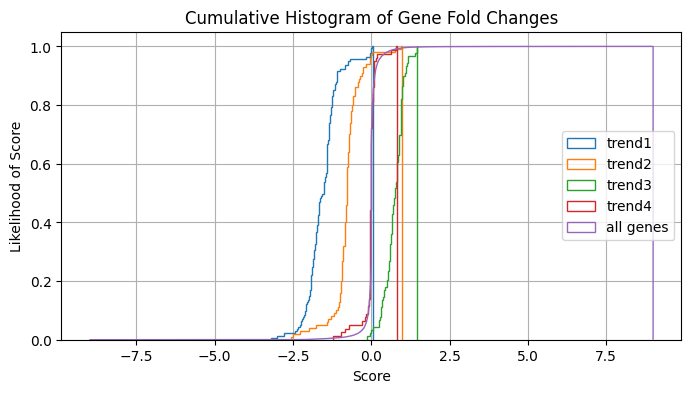

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all genes")
plt.title("Cumulative Histogram of Gene Fold Changes")

Text(0.5, 1.0, 'Cumulative Histogram of Pathway Fold Changes')

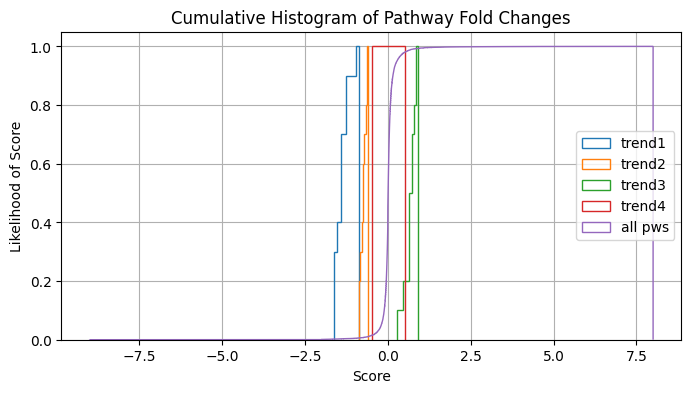

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2pathways[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(node_type="geneset", attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all pws")
plt.title("Cumulative Histogram of Pathway Fold Changes")

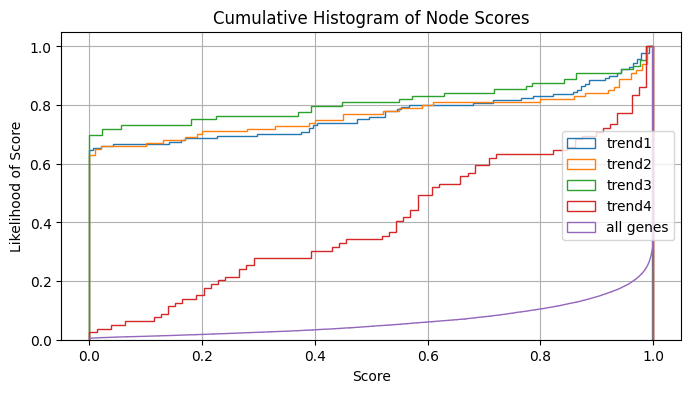

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc"]["sig"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc"]["sig"], ax=ax, title="all genes", node_type="gene")

In [27]:
def geneset_filter(n, kg):

    if kg.node_type_overlap(n, ["disease", "geneset"]):
        if len(kg._get_predecessors(n, ntype="gene")) < 5:
            return False

        if kg.kg.nodes[n]["fc"]["sig"] > 0.1:
            return False
   
    elif kg.node_type_overlap(n, ["gene"]):
        if kg.kg.nodes[n]["fc"]["sig"] > 0.9:
            return False

    else:
        #drug, ncRNA
        if kg.kg.nodes[n]["fc"]["sig"] > 0.9:
            return False

    
    return True

def filter_empty_genesets(n, kg):

    if kg.node_type_overlap(n, ["disease", "geneset"]):
        if len(kg._get_predecessors(n, ntype="gene")) < 3:
            return False

        numKgChildren = len(kg._get_predecessors(n, ntype="gene"))
        numAllChildren = len(dkg._get_predecessors(n, ntype="gene"))

        if (numKgChildren/numAllChildren) < 0.5:
            return False
    

    if kg.node_type_overlap(n, ["gene", "ncRNA"]):
        if len(kg.kg.edges(n)) == 0:
            return False

    return True

In [28]:
all_best_nodes = [x[0] for x in dkg.get_nodes_with_highest_scores(n=3000, score_accessor=lambda x: x["fc_score"], node_filter=geneset_filter)]

for bnodes in [100, 150, 200, 300, 400, 500, 750, 1000, 2000, 2500, 3000]:
    best_nodes = all_best_nodes[0:bnodes]
    for trend in trend2gene:
        trend_overlap = len(set(best_nodes).intersection(trend2gene[trend]))
        pw_overlap = len(set(best_nodes).intersection(trend2pathways[trend]))
        print(bnodes, trend, trend_overlap, trend_overlap/len(trend2gene[trend]), pw_overlap, pw_overlap/len(trend2pathways[trend]))

100 trend1 0 0.0 0 0.0
100 trend2 2 0.02 0 0.0
100 trend3 47 0.5280898876404494 5 0.5
100 trend4 1 0.012658227848101266 0 0.0
150 trend1 0 0.0 0 0.0
150 trend2 2 0.02 0 0.0
150 trend3 65 0.7303370786516854 8 0.8
150 trend4 1 0.012658227848101266 0 0.0
200 trend1 0 0.0 0 0.0
200 trend2 2 0.02 0 0.0
200 trend3 68 0.7640449438202247 9 0.9
200 trend4 1 0.012658227848101266 0 0.0
300 trend1 0 0.0 0 0.0
300 trend2 2 0.02 0 0.0
300 trend3 76 0.8539325842696629 9 0.9
300 trend4 1 0.012658227848101266 0 0.0
400 trend1 0 0.0 0 0.0
400 trend2 2 0.02 0 0.0
400 trend3 77 0.8651685393258427 10 1.0
400 trend4 1 0.012658227848101266 0 0.0
500 trend1 0 0.0 0 0.0
500 trend2 2 0.02 0 0.0
500 trend3 78 0.8764044943820225 10 1.0
500 trend4 1 0.012658227848101266 0 0.0
750 trend1 0 0.0 0 0.0
750 trend2 2 0.02 0 0.0
750 trend3 78 0.8764044943820225 10 1.0
750 trend4 1 0.012658227848101266 0 0.0
1000 trend1 0 0.0 0 0.0
1000 trend2 2 0.02 0 0.0
1000 trend3 78 0.8764044943820225 10 1.0
1000 trend4 1 0.012658227

In [29]:
best_nodes = dkg.get_nodes_with_highest_scores(n=300, score_accessor=lambda x: x["fc_score"], node_filter=geneset_filter)       # nodetype="gene",
dkg_small = dkg.subset_kg([x[0] for x in best_nodes])
dkg_small

KGraph KGraph_vs_KGraph_subset with 300 nodes and 1082 edges

In [30]:
best_nodes[-1]

('UBE2D1', 0.312723706342713)

In [31]:
len(set(dkg_small.kg.nodes).intersection(trend2gene["trend1"]))

0

In [32]:
dkg_filtered = dkg_small.filter_nodes(filter_empty_genesets)
dkg_filtered = dkg_filtered.filter_nodes(filter_empty_genesets)
dkg_filtered

KGraph KGraph_vs_KGraph_subset_filter_filter with 107 nodes and 612 edges

In [33]:
len(set(dkg_filtered.kg.nodes).intersection(trend2gene["trend3"]))

76

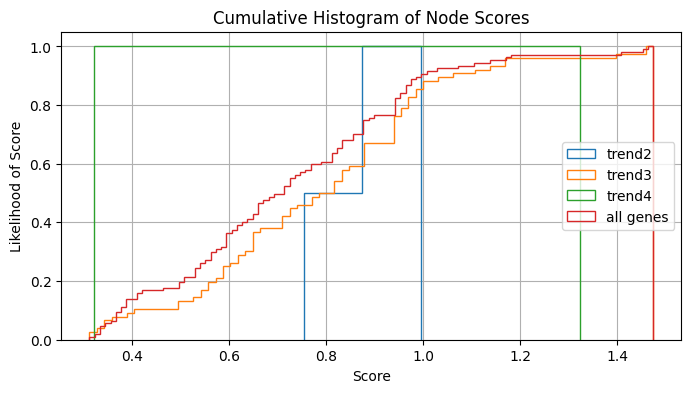

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg_filtered.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg_filtered.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all genes")


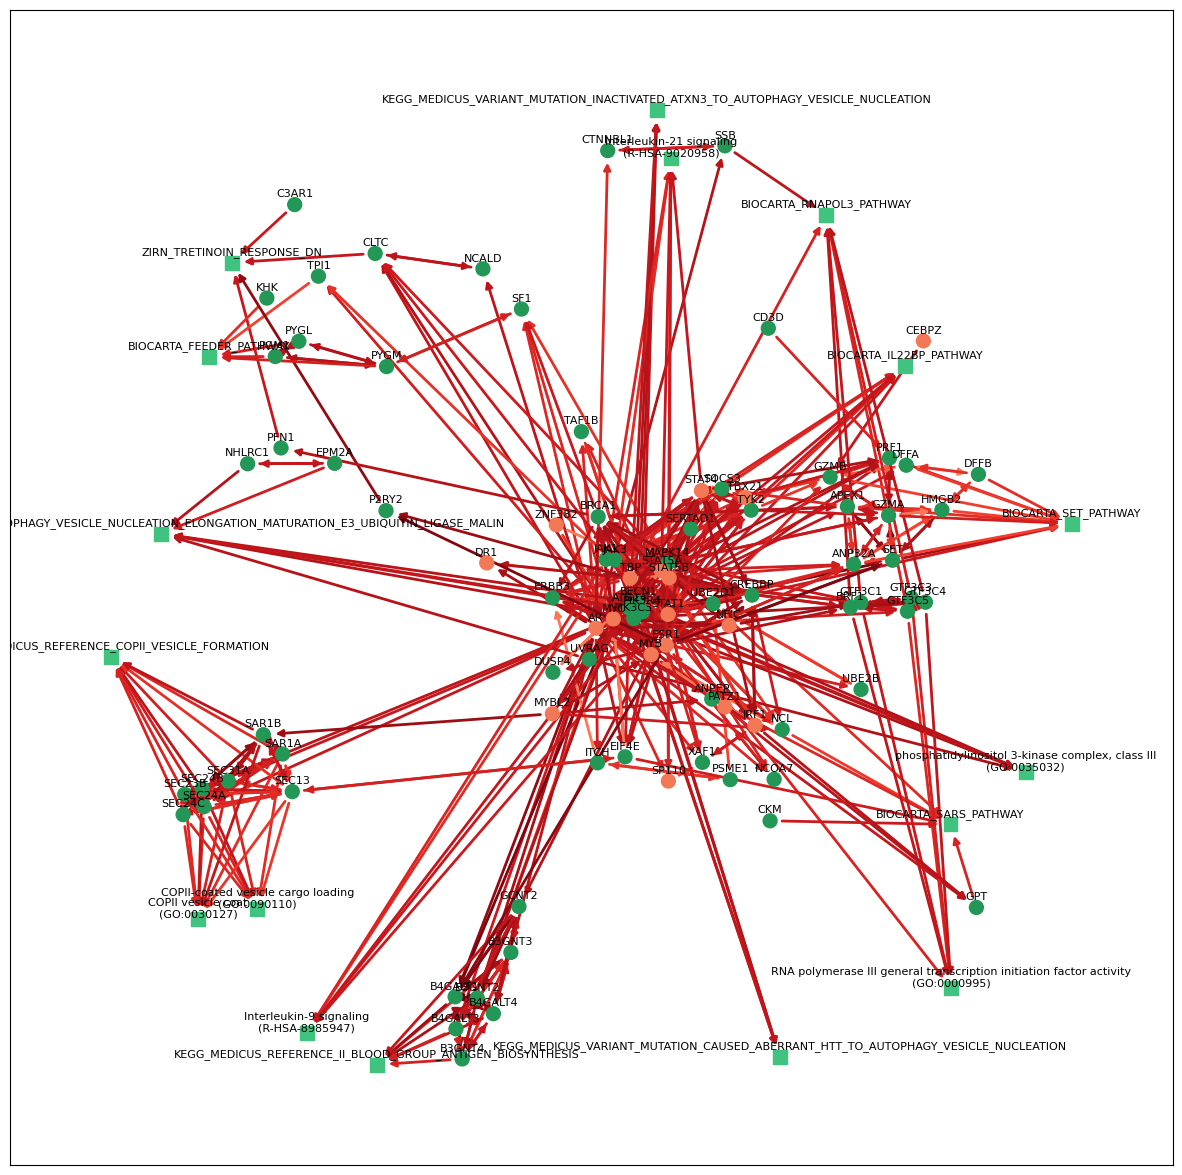

In [35]:
_=dkg_filtered.plot_graph(score_accessor=lambda x: x.get("fc_score", 0), figsize=(15, 15))

In [36]:
dkgModules = dkg_filtered.get_communities_greedymodularity(minEdgeScore=None, resolution=0.5, score_field="fc_score")
dkg_filtered.describe_communities(dkgModules)

Number of communities: 5
Average community size 21.4
Median community size 11.0
Quantile (0,0.25,0.5,0.75,1) community size [ 5. 11. 11. 17. 63.]


In [37]:
def evaluate_communities(modules, target_trend, t2g, t2p, p2g):
    allTargetGenes = set()
    singleTargetGenes = set()

    foundPathways = set()

    for x in modules:
        if len(modules[x]) == 1:

            for y in modules[x]:
                if y in t2g[target_trend]:
                    singleTargetGenes.add(y)
            continue
        target_genes = set(modules[x]).intersection(t2g[target_trend])
        allTargetGenes.update(target_genes)

        if len(modules[x])> 0 and len(target_genes) > 0:
            intGenesets = set(t2p[target_trend]).intersection(modules[x])

            foundPathways.update(intGenesets)
            
            print(x, len(modules[x]), len(target_genes), target_genes, intGenesets)

            for pw in intGenesets:
                pwgenes = dkg_filtered._get_predecessors(pw, ntype="gene")
                print(pw, len(pwgenes), len(p2g.get(pw, [])), pwgenes.intersection(target_genes))
            print()

            for n in modules[x]:
                if n in intGenesets:
                    continue
                    
                if "geneset" in dkg_filtered.kg.nodes[n]["type"]:
                    pwgenes = dkg_filtered._get_predecessors(n, ntype="gene")
                    print("OTHER", n, len(pwgenes), pwgenes.intersection(target_genes))

            print()
            print()

    print(len(allTargetGenes))
    print(len(singleTargetGenes))
    print(len(foundPathways), t2p[target_trend].difference(foundPathways))

In [38]:
evaluate_communities(dkgModules, "trend1", trend2gene, trend2pathways, pathways2genes)

0
0
0 {'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP', 'HEDENFALK_BREAST_CANCER_BRACX_UP', 'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN', 'GREENBAUM_E2A_TARGETS_DN', 'FINETTI_BREAST_CANCER_KINOME_RED', 'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE', 'GHO_ATF5_TARGETS_UP', 'DASU_IL6_SIGNALING_DN', 'AMIT_EGF_RESPONSE_40_MCF10A', 'FARDIN_HYPOXIA_9'}


In [39]:
def evaluate_communities_detail(kg, modules, target_trend, t2g, t2p, p2g, g2t, fullKG=None):

    fndElems = []
    for pw in t2p[target_trend]:

        unknownGenes = set()
        stage_counter = Counter()
        #for s,t in dkg.get_node_edges(pw):
        for s in p2g[pw]:
        
            cont_stages = set()
            for x in modules:
                if s in modules[x]:
                    cont_stages.add(x)

            inKG = s in kg.kg.nodes

            if not inKG:
                unknownGenes.add(s)
            
            print(target_trend, pw, s, g2t[s], inKG, cont_stages)
            if len(cont_stages) > 0:
                for x in cont_stages:
                    stage_counter[x] += 1
            else:
                stage_counter["NA"] += 1

        print(stage_counter)
        
        foundCount = sum([stage_counter[x] for x in stage_counter if not x == "NA"])
        notFoundCount = stage_counter["NA"]
        fndElems.append([pw, foundCount, notFoundCount])

        if not fullKG is None:
            for s in unknownGenes:
                print(s, fullKG.kg.nodes[s])
        
        print()

    print()
    print()

    pwSens = set()
    gSens = set()
    pw2sensitivity = defaultdict(set)
    
    for pw in t2p[target_trend]:

        if pw in kg.kg.nodes:
            pwSens.add(pw)

        for g in p2g[pw]:
            
            if g in kg.kg.nodes:
                pw2sensitivity[pw].add(g)
                gSens.add(g)

    pwSensitivity = len(pwSens) / len(t2p[target_trend])
    geneSensitivity = len(gSens) / len(t2g[target_trend])

    pwGeneSensitivity = {}
    for pw in t2p[target_trend]:
        pwGeneSensitivity[pw] = len(pw2sensitivity[pw]) / len(p2g[pw])


    print("Pathway Sensitivity", pwSensitivity)
    print("Gene Sensitivity", geneSensitivity)
    weightedSens = 0
    allGenes = 0
    for pw in pwGeneSensitivity:
        print("PW-Gene Sensitivity", pw, pwGeneSensitivity[pw])

        weightedSens += pwGeneSensitivity[pw] * len(p2g[pw])
        allGenes += len(p2g[pw])

    print("Weighted Sensitivity", weightedSens/allGenes)    
    
    df = pd.DataFrame.from_records(fndElems, columns=["pathway", "found", "missing"])
    df.plot(x="pathway", kind='bar', stacked=True,
            title='Retained Genes/TFs per pathway for {}'.format(target_trend))
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return df


trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS TP53 {'gene', 'tf'} False set()
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS B4GALT1 {'gene'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS DR1 {'tf'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS MYB {'tf'} True {'cc_0'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS B3GNT3 {'gene'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS MYBL2 {'tf'} True {'cc_0'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS B3GNT4 {'gene'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS GCNT2 {'gene'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS AR {'tf'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS SERTAD1 {'tf'} True {'cc_1'}
trend3 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSY

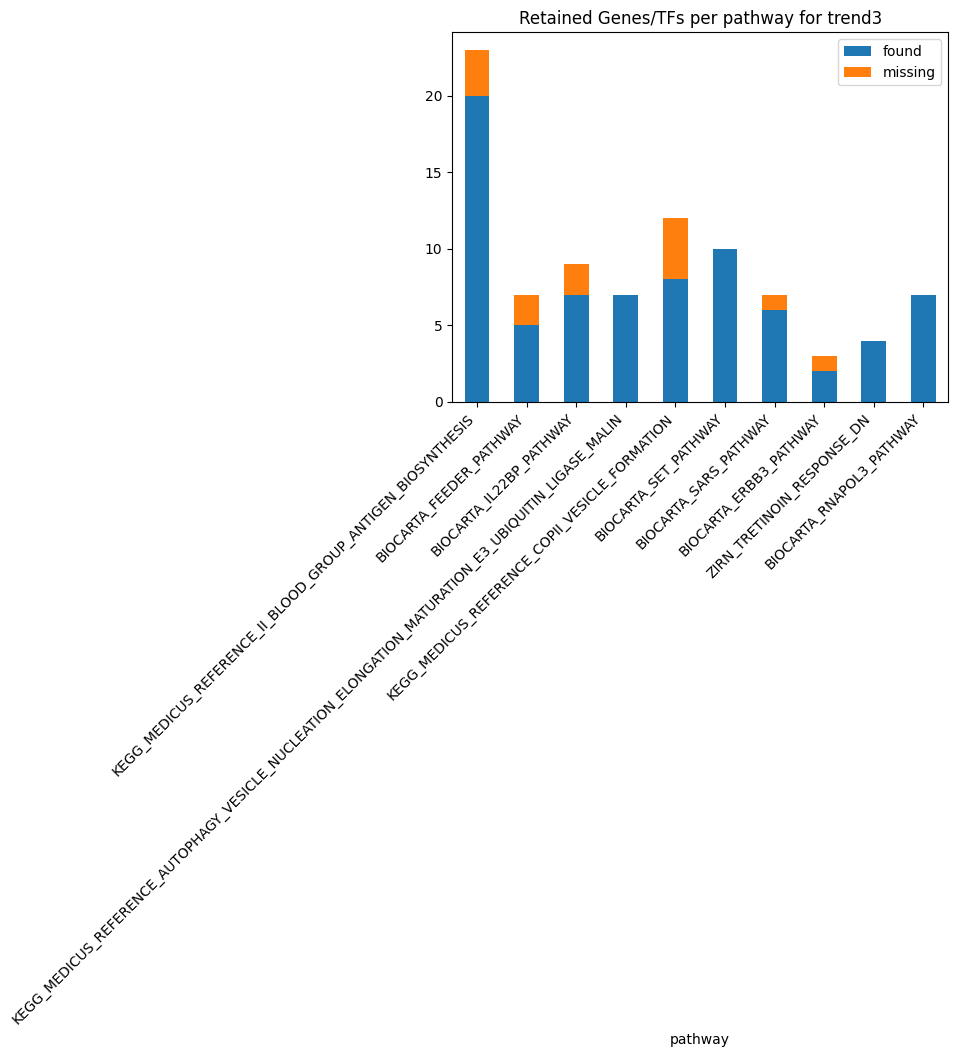

In [40]:
pwc = evaluate_communities_detail(dkg_filtered, dkgModules, "trend3", trend2gene, trend2pathways, pathways2genes, gene2type, fullKG=dkg)

In [41]:
pd.set_option('display.max_rows', None)
display(simulatedGenes[simulatedGenes.trend=="trend3"].head(None))
pd.set_option('display.max_rows', 50)

,wildtype,stage1,stage2,stage3,geneset,trend,element_type,gene
245,1,2,4,1,ZIRN_TRETINOIN_RESPONSE_DN,trend3,gene,C3AR1
246,1,2,4,1,ZIRN_TRETINOIN_RESPONSE_DN,trend3,gene,CLTC
247,1,2,4,1,ZIRN_TRETINOIN_RESPONSE_DN,trend3,gene,P2RY2
248,1,2,4,1,ZIRN_TRETINOIN_RESPONSE_DN,trend3,gene,PFN1
249,1,2,4,1,BIOCARTA_ERBB3_PATHWAY,trend3,gene,ERBB3
250,1,2,4,1,BIOCARTA_ERBB3_PATHWAY,trend3,gene,NRG1
251,1,2,4,1,BIOCARTA_ERBB3_PATHWAY,trend3,gene,UBE2D1
252,1,2,4,1,BIOCARTA_FEEDER_PATHWAY,trend3,gene,HK1
253,1,2,4,1,BIOCARTA_FEEDER_PATHWAY,trend3,gene,KHK
254,1,2,4,1,BIOCARTA_FEEDER_PATHWAY,trend3,gene,MPI
